## Wind directions from Kepert BL model

### Test v05

Smooth the input wind profile ==> Not conclusive. The discontinuities are really just due to lcations where I = V / r, and if I want to remove that, it implies having a non-realistic wind profile.

- The smoothing does not change that much on Holland. I need to smooth too much in order for the irrgularities at I = V / r to disappear.

- So I try the Willoughby. If I need to sooth properly in the end maybe use the last message of https://stats.stackexchange.com/questions/197509/how-to-smooth-data-and-force-monotonicity. The package is in R but there is probably a way to call it in Python.

- Même avec Willoughby ça ne marche pas. Donc utiliser le modèle uniquement dans la région dans laquelle il est valide, i.e les points loins de I = V / r

In [2]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.interpolate import griddata

# Statistics
# from sklearn import linear_model, neighbors
# from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [3]:
#########################
### General functions ###
#########################
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

# def h80(r, vm, rm, B, lat, vmin=0):
#     '''Holland 1980 profile.'''
#     fcor = coriolis(lat)
#     V    = r * 0.
#     V    = vmin + np.sqrt((vm ** 2) * ((rm / r) ** B) * np.exp(1 - (rm / r) ** B) + (r * fcor / 2) ** 2) - (r * fcor / 2)
#     return V

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

#########################
### KEPERT 2001 MODEL ###
#########################
# Inertial stability
def I(Rs, Vs, fcor):
    dr   = np.diff(Rs[0, :])[0] # meters
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=1) + Vs / Rs + fcor
    return np.sqrt(ksi * zeta)

# Coefficients
def sqrt_alpha_beta(Rs, Vs, fcor):
    '''Corresponds to sqrt(alpha / beta).'''
    dr   = np.diff(Rs[0, :])[0] # meteRs
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=1) + Vs / Rs + fcor
    return np.sqrt(ksi / zeta)

def eta(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * ((Vs / Rs) + I(Rs, Vs, fcor))))

def ki(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * I(Rs, Vs, fcor)))

def psi(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / abs(K * ((Vs / Rs) - I(Rs, Vs, fcor))))

# Amplitudes
def A0(Rs, Vs, K, C, fcor):
    num = -ki(Rs, Vs, K, C, fcor) * Vs * [1 + 1j * (1 + ki(Rs, Vs, K, C, fcor))]
    den = 2 * ki(Rs, Vs, K, C, fcor) ** 2 + 3 * ki(Rs, Vs, K, C, fcor) + 2
    return num / den

def A1(Rs, Vs, Ut, K, C, fcor):
    num = -eta(Rs, Vs, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 - sqrt_alpha_beta(Rs, Vs, fcor)) * psi(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [(2 + 2j) * (1 + eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)) + 3 * eta(Rs, Vs, K, C, fcor) + 3j * psi(Rs, Vs, K, C, fcor)]
    return num / den

def A_1(Rs, Vs, Ut, K, C, fcor):
    num = -psi(Rs, Vs, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(Rs, Vs, fcor)) * eta(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [(2 + 2j) * (1 + eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)) + 3 * psi(Rs, Vs, K, C, fcor) + 3j * eta(Rs, Vs, K, C, fcor)]
    return num / den

def A1_prime(Rs, Vs, Ut, K, C, fcor):
    num = -eta(Rs, Vs, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 - 1j) * (1 - sqrt_alpha_beta(Rs, Vs, fcor)) * psi(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [2 + 2j + 3 * (eta(Rs, Vs, K, C, fcor) + psi(Rs, Vs, K, C, fcor)) + (2 - 2j) * eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)]
    return num / den

def A_1_prime(Rs, Vs, Ut, K, C, fcor):
    num = -psi(Rs, Vs, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(Rs, Vs, fcor)) * eta(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [2 - 2j + 3 * (eta(Rs, Vs, K, C, fcor) + psi(Rs, Vs, K, C, fcor)) + (2 + 2j) * eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)]
    return num / den

# Radial and tangential wind components at the surface (z = 0)
def u0(Rs, Vs, K, C, fcor):
    '''At the surface (z = 0)'''
    u0 = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A0(Rs, Vs, K, C, fcor))
    return np.reshape(u0,  np.shape(u0)[1:])

def v0(Rs, Vs, K, C, fcor):
    '''At the surface (z = 0)'''
    v0 = np.imag(A0(Rs, Vs, K, C, fcor))
    return np.reshape(v0,  np.shape(v0)[1:])

def u1(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1(Rs, Vs, Ut, K, C, fcor)       * np.exp(1j * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(1j * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v1(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A1(Rs, Vs, Ut, K, C, fcor)       * np.exp(1j * THs))
    otherwise = np.imag(A1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(1j * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

def u_1(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1(Rs, Vs, Ut, K, C, fcor)       * np.exp(-1j * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(-1j * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v_1(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A_1(Rs, Vs, Ut, K, C, fcor)       * np.exp(-1j * THs))
    otherwise = np.imag(A_1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(-1j * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

# TOTAL WIND COMPONENTS IN THE BL
def u_BL(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    return u_1(THs, Rs, Vs, Ut, K, C, fcor) + u0(Rs, Vs, K, C, fcor) + u1(THs, Rs, Vs, Ut, K, C, fcor)

def v_BL(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    return Vs + v_1(THs, Rs, Vs, Ut, K, C, fcor) + v0(Rs, Vs, K, C, fcor) + v1(THs, Rs, Vs, Ut, K, C, fcor)

# FINAL MODEL
def kepert2001(THs, Rs, Vs, Ut, K, C, fcor):
    # Returns Kepert wind speeds
    u_K01   = u_BL(THs, Rs, Vs, Ut, K, C, fcor)
    v_K01   = v_BL(THs, Rs, Vs, Ut, K, C, fcor)  

    # Adds the translation speed
    Utu     = Ut * np.cos(THs) # Radial component of Ut
    Utv     = -Ut * np.sin(THs) # Tangential component of Ut
    
    return u_K01 + Utu, v_K01 + Utv

#########################
### CREATE STRUCTURES ###
#########################
def get_xrDataset_polar(rs, ths, u_K01, v_K01):
    kep_pol = xr.Dataset(
        data_vars={
            'wind_speed': (('theta', 'rad'), np.sqrt(v_K01 ** 2 + u_K01 ** 2)),
            'rad_wind':   (('theta', 'rad'), u_K01),
            'tan_wind':   (('theta', 'rad'), v_K01),
        },
        coords={
            'theta': np.rad2deg(ths),
            'rad': rs,
        }
    )
    kep_pol['inflow_angle'] = np.rad2deg(np.arctan((kep_pol.rad_wind / kep_pol.tan_wind))) # Inflow Angle Polar
    return kep_pol

def get_xrDataset_cartesian(Xs, Ys, x_ref, y_ref, dim_ref, kep_pol):
    '''Slower than its polar counterpart, because 4 interpolations are performed.'''
    kep_car = xr.Dataset(
        data_vars={
            'wind_speed':   (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
            'rad_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'tan_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'inflow_angle': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
        },
        coords={
            'x': dim_ref,
            'y': dim_ref,
        }
    )
    return kep_car

#########################
###   MODEL FITTING   ###
#########################
def wind_reduction_factor(Rs, Vs, K, C, fcor):
    '''wrf = surface azim. wind / gradient azim. wind'''
    ki_cst  = ki(Rs, Vs, K, C, fcor)
    num     = ki_cst ** 2 + 2 * ki_cst + 2
    den     = 2 * ki_cst ** 2 + 3 * ki_cst + 2
    return num / den

def wn1(thetas, a, phi, c):
    return a * np.cos(thetas + phi) + c

def get_wn1(thetas, wind_speed, initial_condition=15, upper_bound=80):
    '''
    initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
    upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
    '''
    # Fitting process
    popt, pcov = curve_fit(
        f=wn1,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi / 2, initial_condition],
        bounds=([1., 0., 0.1], [upper_bound, np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a, phi, c = popt[0], popt[1], popt[2]
    return a, phi, c

def get_kepert_asymmetries(THs, Rs, ths, rs, Vs, Ut, K, C, fcr):
    # Estimate the wind at the top of the BL with the wind reduction factor
    wrf    = wind_reduction_factor(Rs, Vs, K, C, fcr) # azimuthal wind
    # wrf    = wind_reduction_factor_total_wind(Rs, Vs, K, C, fcr, Ut) # total wind
    Vs_try = Vs / wrf
    
    # Apply Kepert's model
    u_K01, v_K01 = kepert2001(THs, Rs, Vs, Ut, K, C, fcr) # Takes 3-4 seconds
    kep_pol      = get_xrDataset_polar(rs, ths, u_K01, v_K01)
    
    # Test
    ASS = []
    for rad in np.linspace(ds.rmx - 2000, 2 * ds.rps, 20): # WTF? TO UPDATE: ds should be as input parameters of the function (and change its name to avoid errors)
        as_rmx, _,  _ = get_wn1(np.deg2rad(kep_pol.theta), kep_pol.wind_speed.sel(rad=rad, method='nearest'), float(ds.vps), float(ds.vmx))
        ASS.append(as_rmx)
    plt.plot(np.linspace(ds.rmx - 2000, 2 * ds.rps, 20), ASS, label='K = {}'.format(K))
    
    # kep_pol.wind_speed.sel(rad=float(ds.rmx), method='nearest').plot(label='K = {}'.format(K))
    
    # # Plot asymmetries
    # kep_pol.wind_speed.sel(rad=float(ds.rmx), method='nearest').plot(label='K = {}'.format(K))
    # kep_pol.wind_speed.sel(rad=float(ds.rps), method='nearest').plot(label='K = {}'.format(K))
    
    # Extract WN1 metrics
    ak_rmx, phi, ck_rmx = get_wn1(np.deg2rad(kep_pol.theta), kep_pol.wind_speed.sel(rad=float(ds.rmx), method='nearest'), float(ds.vps), 2 * float(ds.vmx)) # Kepert at Rmax
    # print(ak_rmx, phi, ck_rmx)
    # plt.plot(kep_pol.theta, wn1(np.deg2rad(kep_pol.theta), ak_rmx, phi, ck_rmx))
    ak_rps, _, ck_rps = get_wn1(np.deg2rad(kep_pol.theta), kep_pol.wind_speed.sel(rad=float(ds.rps), method='nearest'), float(ds.vps), float(ds.vmx)) # Kepert at R+
    
    return ak_rmx, ck_rmx, ak_rps, ck_rps

In [4]:
#########################
###  HYPERPARAMETERS  ###
#########################
# Reference grids
rs           = np.linspace(100, 5e5, 5000)
ths          = np.linspace(0, 2 * np.pi, 361)                         # in radians
Rs, THs      = np.meshgrid(rs, ths)                                   # shape (361, 5000)
Xs, Ys       = pol2cart(Rs, THs)                                      # to create cartesian dataset
dim_ref      = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000 # to create cartesian dataset
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)                          # to create cartesian dataset

In [93]:
### OPEN THE SAR IMAGE
# Need to choose a TC for which speed is sufficiently high during most intense phases of the TC
# If possible >2023 to have RCM
# I would like to have a collocated Ascat on the RCM acquisition!!

dsg      = xr.open_dataset('/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc')
vls, cts = np.unique(dsg.name, return_counts=True)
print(vls[cts >= 10])

dsg.where(dsg.name == 'DORA', drop=True).isel(time=0).file
ds   = dsg.where(dsg.name == 'DORA', drop=True).isel(time=0)
# a   = xr.open_dataset('/home/arthur/data/cyclobs/RCM/sar_files/s1a-ew-owi-ca-20230809t165107-20230809t165210-000003-05FD3D_sw_ep052023_cyclone_polar.nc').isel(time=0) # time = 8, Dora
dsp  = xr.open_dataset('/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM_old/sar_files/rcm3-sc50mc-owi-ca-20230802t132047-20230802t132203-00003-______sw_ep052023_cyclone_polar.nc').isel(time=0) # time = 7, Dora

['ANGGREK' 'BERYL' 'BHEKI' 'DARIAN' 'DIKELEDI' 'DORA' 'DORIAN' 'ERNESTO'
 'FRANKLIN' 'FREDDY' 'GILMA' 'HECTOR' 'HONE' 'ISAAC' 'JASPER' 'KHANUN'
 'KIRK' 'KOINU' 'KONG-REY' 'LAN' 'LEE' 'LESLIE' 'LIDIA' 'MAN-YI' 'MARGOT'
 'MARIA' 'MAWAR' 'PHILIPPE' 'RAFAEL' 'SAM' 'SAOLA' 'SHANSHAN' 'SURIGAE'
 'TAMMY' 'TRAMI' 'YAGI' 'YINXING']


In [94]:
### Initialize
# Fixed parameters
vmx = float(ds.vmx_hol)
rmx = float(ds.rmx_hol)
vmn = float(ds.vmn_hol)
B   = float(ds.B_hol)
lat = float(ds.lat)
fcr = float(ds.fcor)
Ut  = float(ds.speed)

# Holland with fixed parameters
# V   = h80(rs, vmx, rmx, B, lat, vmn)
V   = holland_profile(rs, lat, B, vmn, rmx, vmx)
Vs  = np.stack([V for i in range(np.shape(THs)[0])]) # Shape (361, 5000)

# Error threshold when fitting WN1s
eps = 0.1

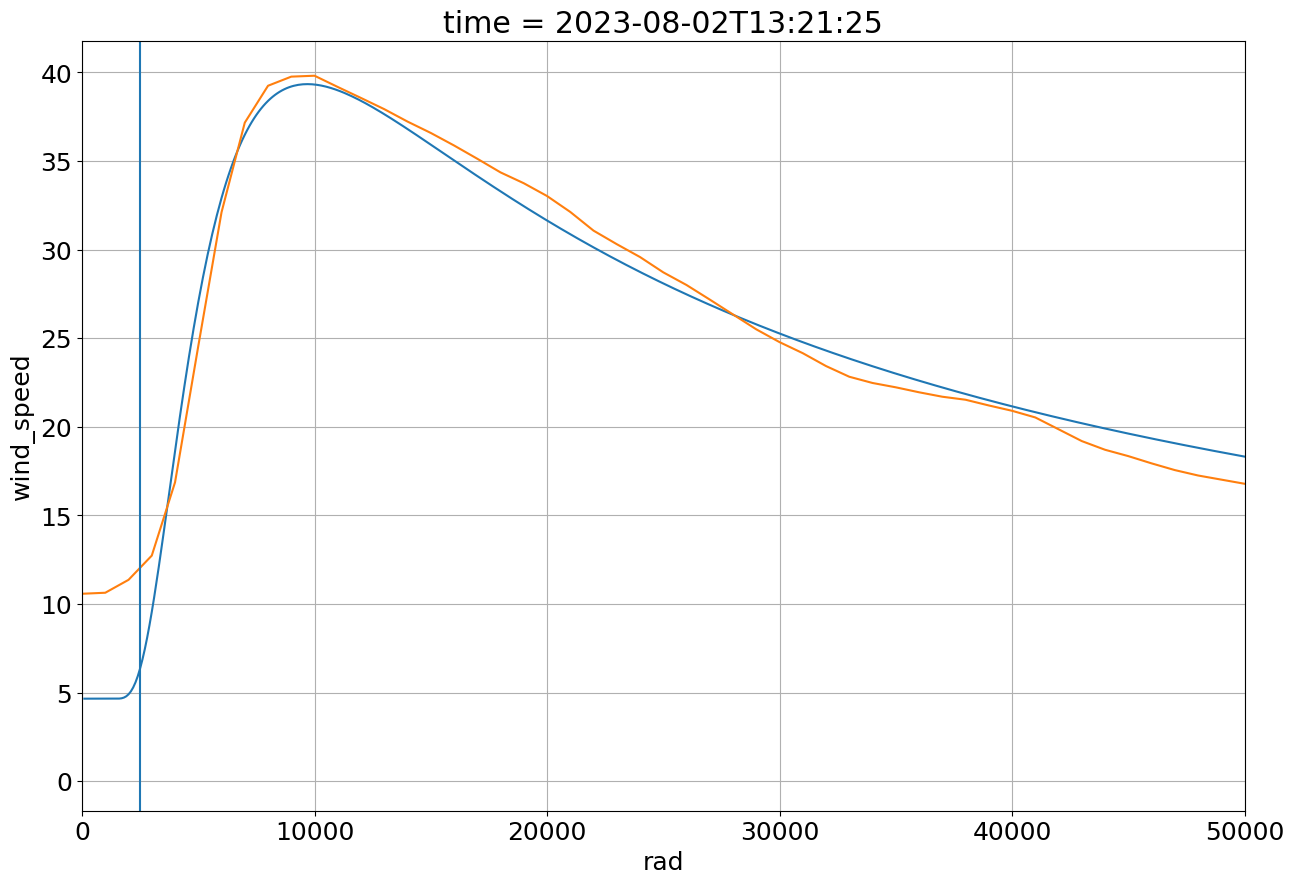

In [95]:
plt.plot(rs, V)
dsp.wind_speed.mean(dim='theta', skipna=True).plot()
plt.xlim(0, 50000)
plt.grid()
plt.axvline(2500)

In [277]:
# from scipy.interpolate import UnivariateSpline

# # Vorticity
# dr   = np.diff(Rs[0, :])[0] # meters
# vort = np.gradient(V, dr, axis=0) + V / rs

# # Create the interpolator
# interp = pchip(rs, vort)

# # Select smoothed parts
# idx_split    = 25
# sampled_rs   = rs.tolist()[:idx_split:5] + rs.tolist()[idx_split:]
# sampled_vort = vort.tolist()[:idx_split:5] + vort.tolist()[idx_split:]

# # Smoothing
# k   = 3 # poly-order
# spl = UnivariateSpline(sampled_rs[::10], sampled_vort[::10], s=0.00001, k=k)
# vort_smth = spl(rs)

# # Plot
# plt.plot(rs, vort)
# plt.plot(rs, vort_smth, c='r')
# plt.xlim(0, 20000)
# plt.grid()

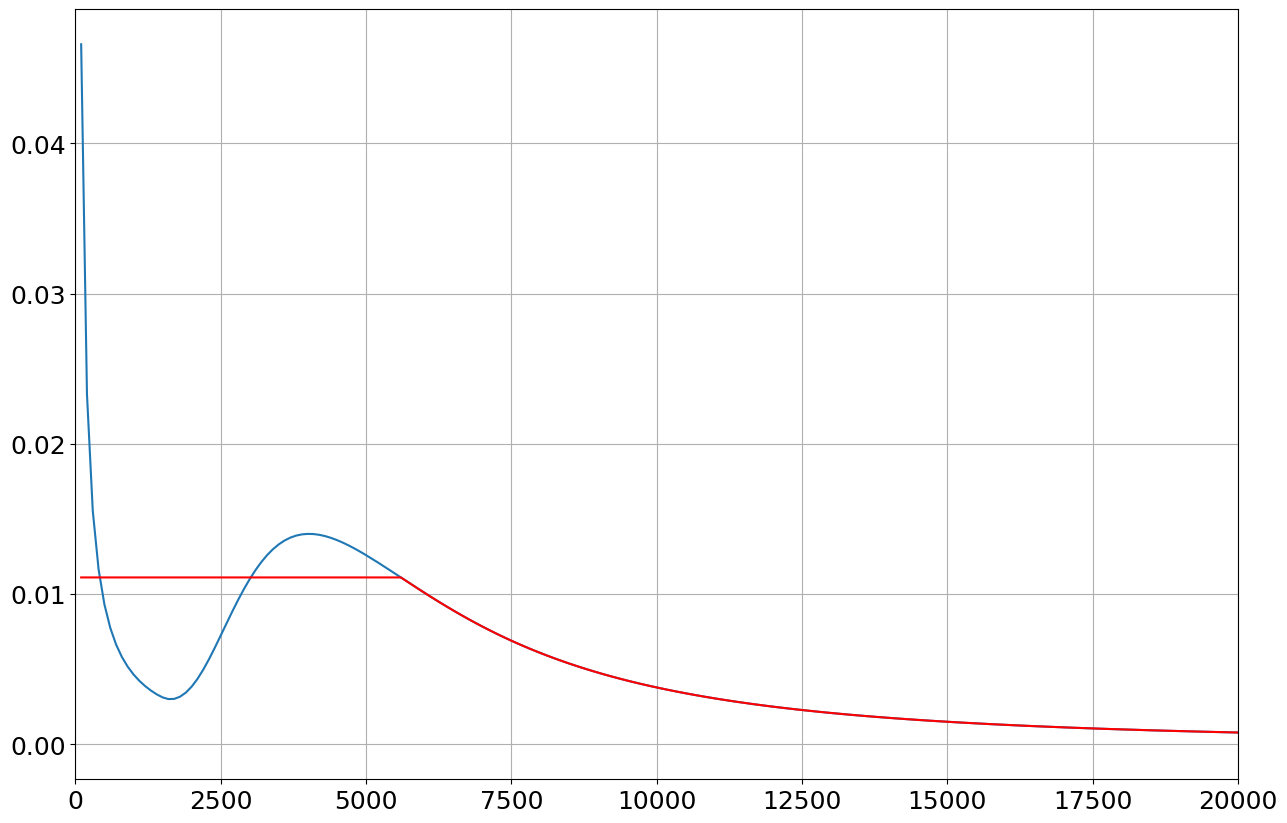

In [352]:
# Vorticity
dr   = np.diff(Rs[0, :])[0] # meters
vort = np.gradient(V, dr, axis=0) + V / rs

# Smoothing
idx_split = 55
# idx_split = 80
vort_smth = copy.deepcopy(vort)
vort_smth[:idx_split] = vort[idx_split]

# Plot
plt.plot(rs, vort)
plt.plot(rs, vort_smth, c='r')
plt.xlim(0, 20000)
plt.grid()

In [353]:
### Integrate vorticity to retrieve V
r_zeta   = rs * vort_smth # r * zeta
integral = np.zeros_like(r_zeta)
for idx_fin in tqdm(range(len(rs) - 1)):
    integral[idx_fin + 1] = np.trapezoid(r_zeta[:idx_fin + 1], rs[:idx_fin + 1], dr)
V_smth   = (1 / rs) * integral

  0%|          | 0/4999 [00:00<?, ?it/s]

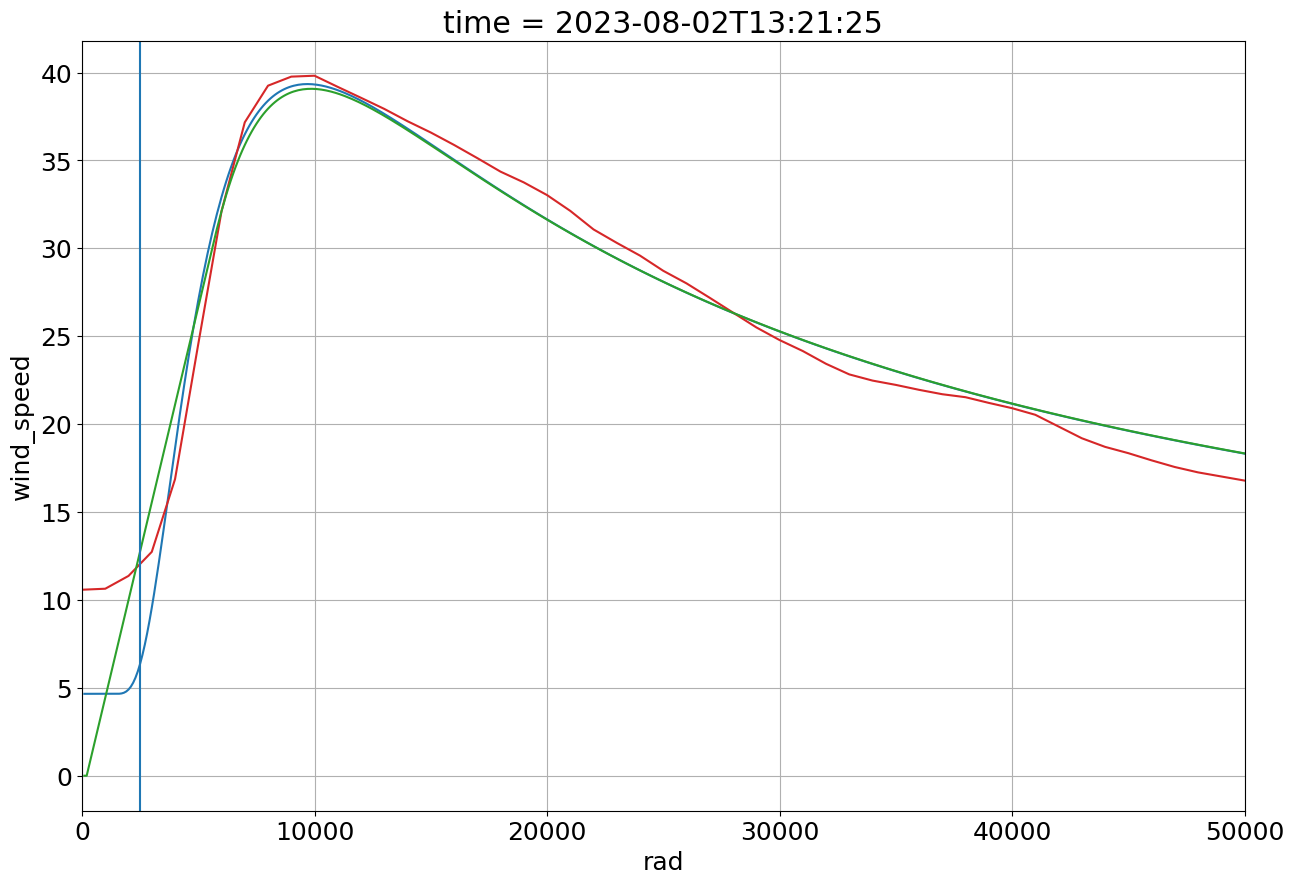

In [354]:
plt.plot(rs, V, c='tab:blue')
dsp.wind_speed.mean(dim='theta', skipna=True).plot(c='tab:red')
plt.plot(rs, V_smth, c='tab:green')
plt.xlim(0, 50000)
plt.grid()
plt.axvline(2500)

22900.0 57000.0


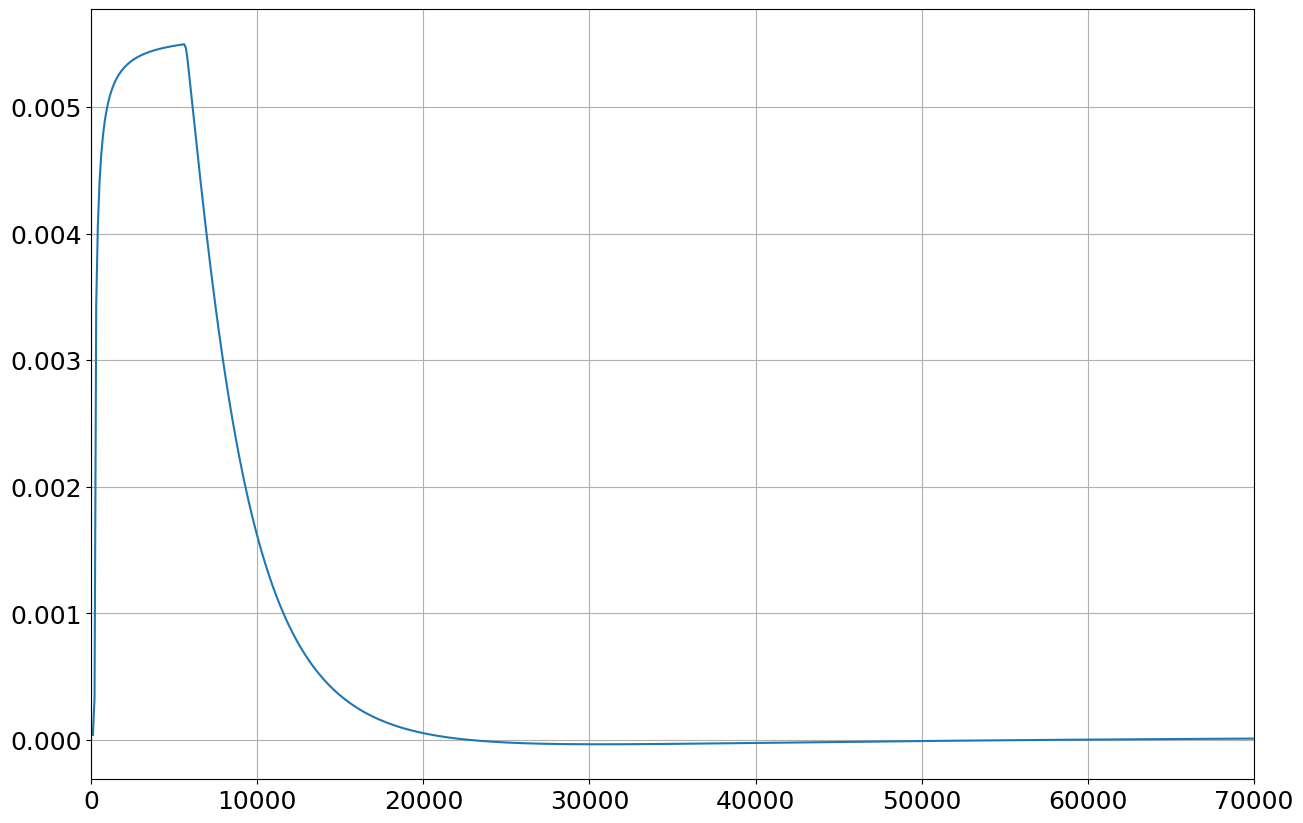

In [355]:
# Try
Vs  = np.stack([V_smth for i in range(np.shape(THs)[0])]) # Shape (361, 5000)

# I ~ V/r radii
try:
    I_Vr         = (I(Rs, Vs, fcr) - Vs / rs)[0, :]    # I - V/r
    r_stt, r_end = rs[I_Vr <= 0][0], rs[I_Vr <= 0][-1] # Define the bounds
except IndexError:
    r_stt = r_end = np.nan

plt.plot(rs, (I(Rs, Vs, fcr) - Vs / rs)[0, :])
plt.grid()
plt.xlim(0, 70000)

print(r_stt, r_end)

22600.0 57000.0


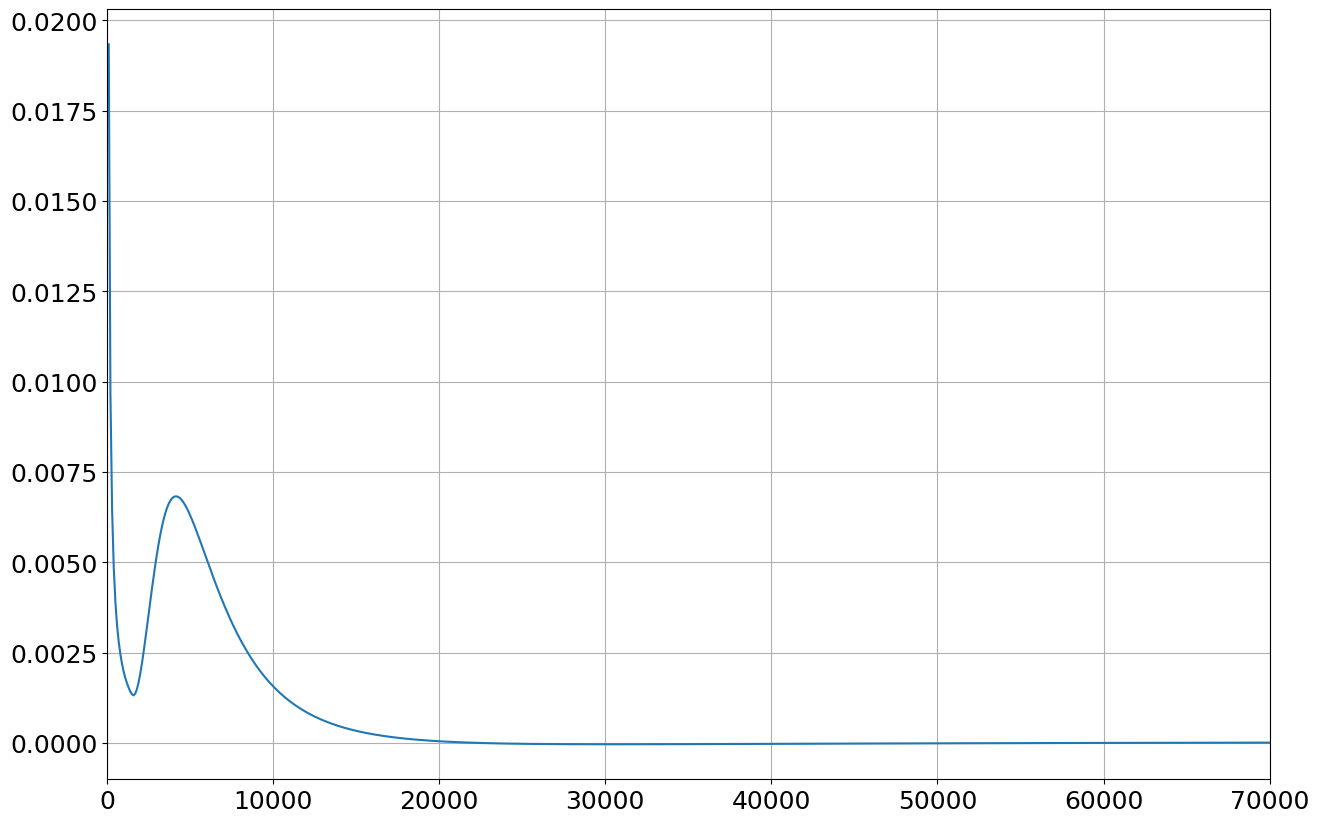

In [324]:
# Try
Vs  = np.stack([V for i in range(np.shape(THs)[0])]) # Shape (361, 5000)

# I ~ V/r radii
try:
    I_Vr         = (I(Rs, Vs, fcr) - Vs / rs)[0, :]    # I - V/r
    r_stt, r_end = rs[I_Vr <= 0][0], rs[I_Vr <= 0][-1] # Define the bounds
except IndexError:
    r_stt = r_end = np.nan

plt.plot(rs, (I(Rs, Vs, fcr) - Vs / rs)[0, :])
plt.grid()
plt.xlim(0, 70000)

print(r_stt, r_end)

In [357]:
def willoughby_profile_no_smooth(r, n, X1, Vmin, Rmax, Vmax):
    '''No polynomial ramp smoothing here.
    We assume V(0) = Vmin != 0 to fit SAR data'''
    V    = r * 0.
    Vinf = (Vmax - Vmin) * ((r / Rmax) ** n) + Vmin
    Vsup = (Vmax - Vmin) * np.exp((-1.) * ((r - Rmax) / X1)) + Vmin
    V[r <=Rmax] = Vinf[r <=Rmax]
    V[r > Rmax] = Vsup[r > Rmax]
    return V

In [375]:
BDS_WIL = {
    'n':      [0.01, 5.],
    'X1':     [1, 500. * 1000],
    'Vmin':   [0, 50],
    'Rmax':   [5 * 1000, 500 * 1000],
    'Vmax':   [10, 100],   
}

In [376]:
wsm = dsp.wind_speed.mean(dim='theta', skipna=True).dropna(dim='rad')

# Willoughby
popt, pcov = curve_fit(
    willoughby_profile_no_smooth, 
    np.array(wsm.rad), 
    np.array(wsm), 
    p0=[1., 20 * 1000, 5, 20 * 1000, 40], 
    bounds=(
        tuple([BDS_WIL[e][0] for e in BDS_WIL.keys()]), # NB: lat is fixed
        tuple([BDS_WIL[e][1] for e in BDS_WIL.keys()])
    ) 
) 
n_wil, X1_wil, vmn_wil, rmx_wil, vmx_wil = popt

print(n_wil, X1_wil, vmn_wil, rmx_wil, vmx_wil)

Vw = willoughby_profile_no_smooth(rs, n_wil, X1_wil, vmn_wil, rmx_wil, vmx_wil)

1.6244899184196397 47301.36117584093 5.9952637595654386 7188.22349084966 39.05754558007884


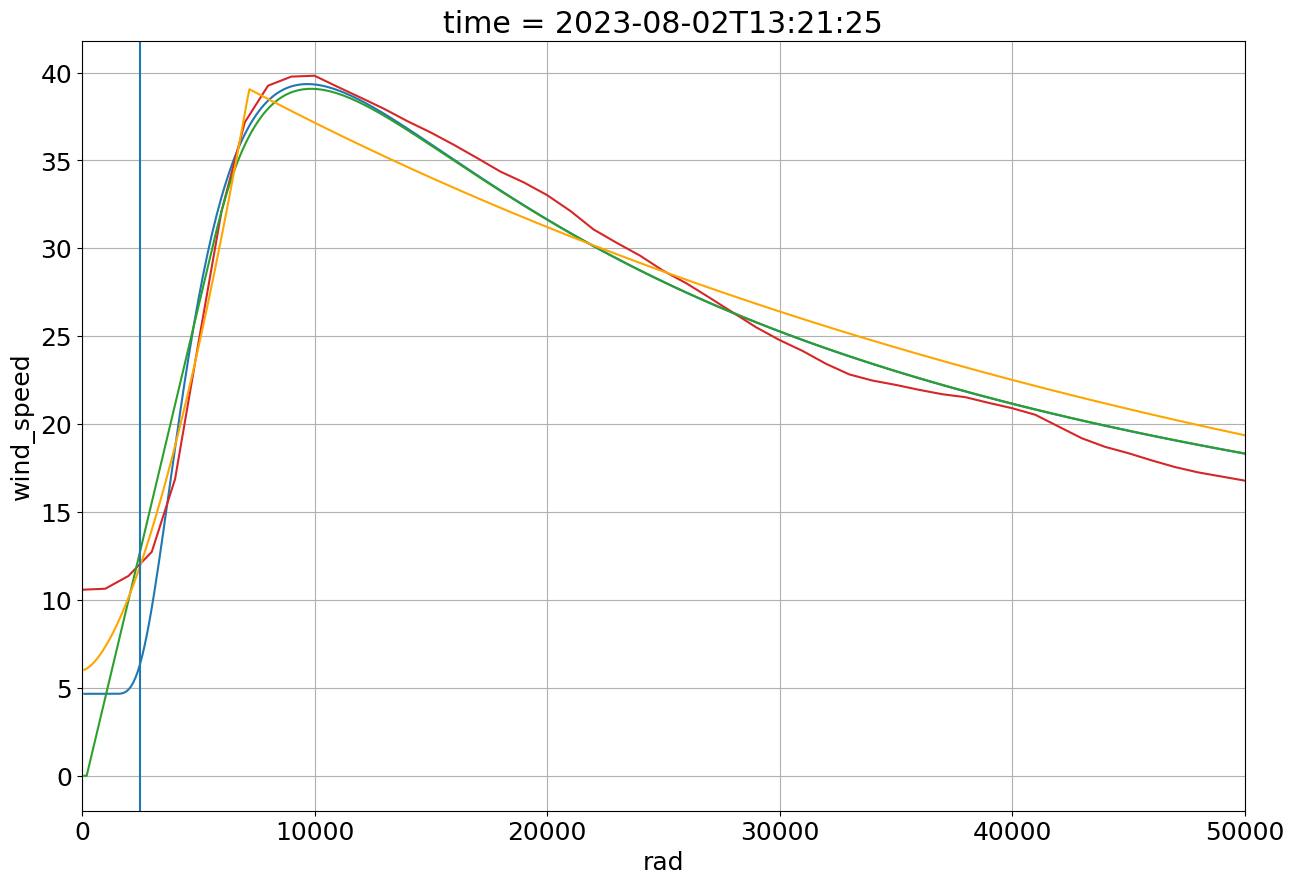

In [379]:
plt.plot(rs, V, c='tab:blue')
dsp.wind_speed.mean(dim='theta', skipna=True).plot(c='tab:red')
plt.plot(rs, V_smth, c='tab:green')
plt.plot(rs, Vw, c='orange')
plt.xlim(0, 50000)
plt.grid()
plt.axvline(2500)

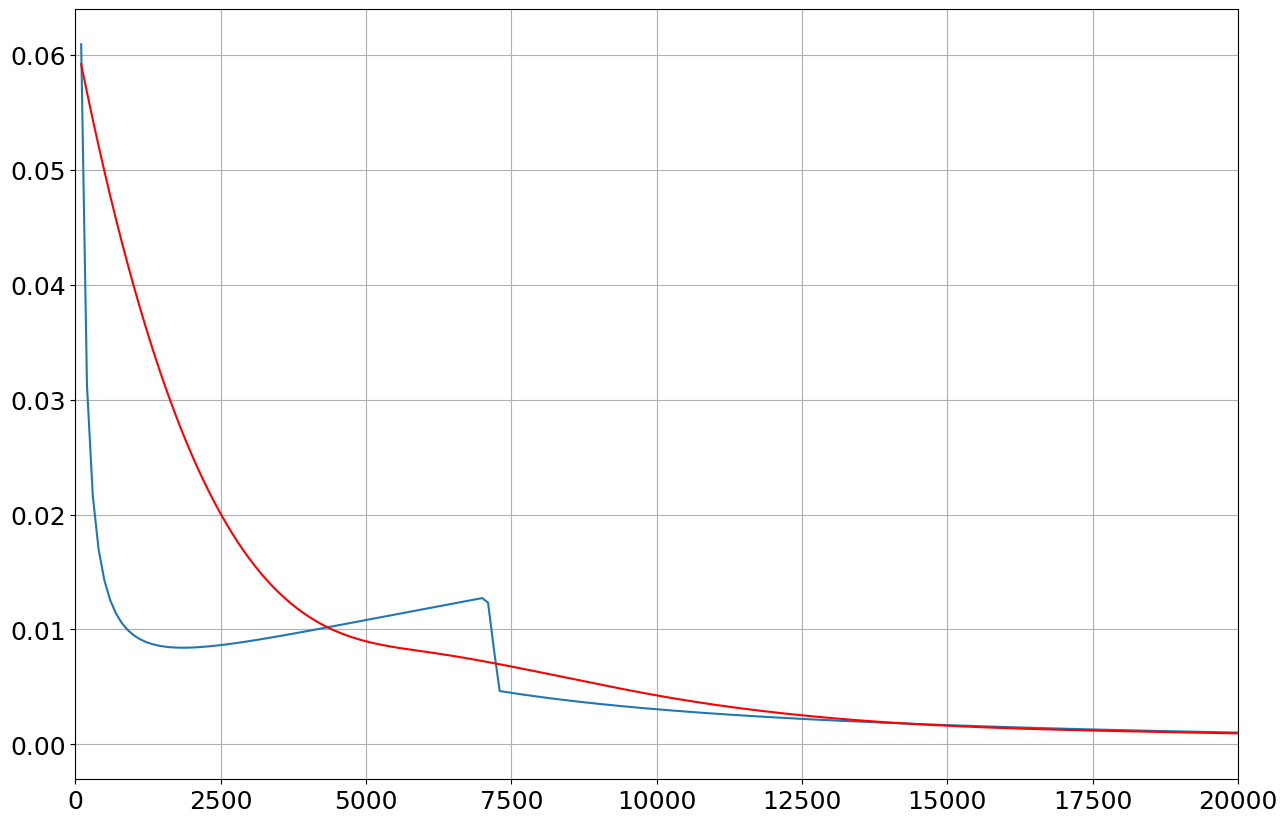

In [423]:
from scipy.interpolate import UnivariateSpline

# Vorticity
dr   = np.diff(Rs[0, :])[0] # meters
vort = np.gradient(Vw, dr, axis=0) + Vw / rs

# Create the interpolator
interp = pchip(rs, vort)

# Select smoothed parts
idx_split    = 25
sampled_rs   = rs.tolist()[:idx_split:5] + rs.tolist()[idx_split:]
sampled_vort = vort.tolist()[:idx_split:5] + vort.tolist()[idx_split:]

# Smoothing
k   = 3 # poly-order
spl = UnivariateSpline(sampled_rs[::10], sampled_vort[::10], s=0.0001, k=k)
vort_smth = spl(rs)

# Plot
plt.plot(rs, vort)
plt.plot(rs, vort_smth, c='r')
plt.xlim(0, 20000)
plt.grid()

In [424]:
### Integrate vorticity to retrieve V
r_zeta   = rs * vort_smth # r * zeta
integral = np.zeros_like(r_zeta)
for idx_fin in tqdm(range(len(rs) - 1)):
    integral[idx_fin + 1] = np.trapezoid(r_zeta[:idx_fin + 1], rs[:idx_fin + 1], dr)
V_smth   = (1 / rs) * integral

  0%|          | 0/4999 [00:00<?, ?it/s]

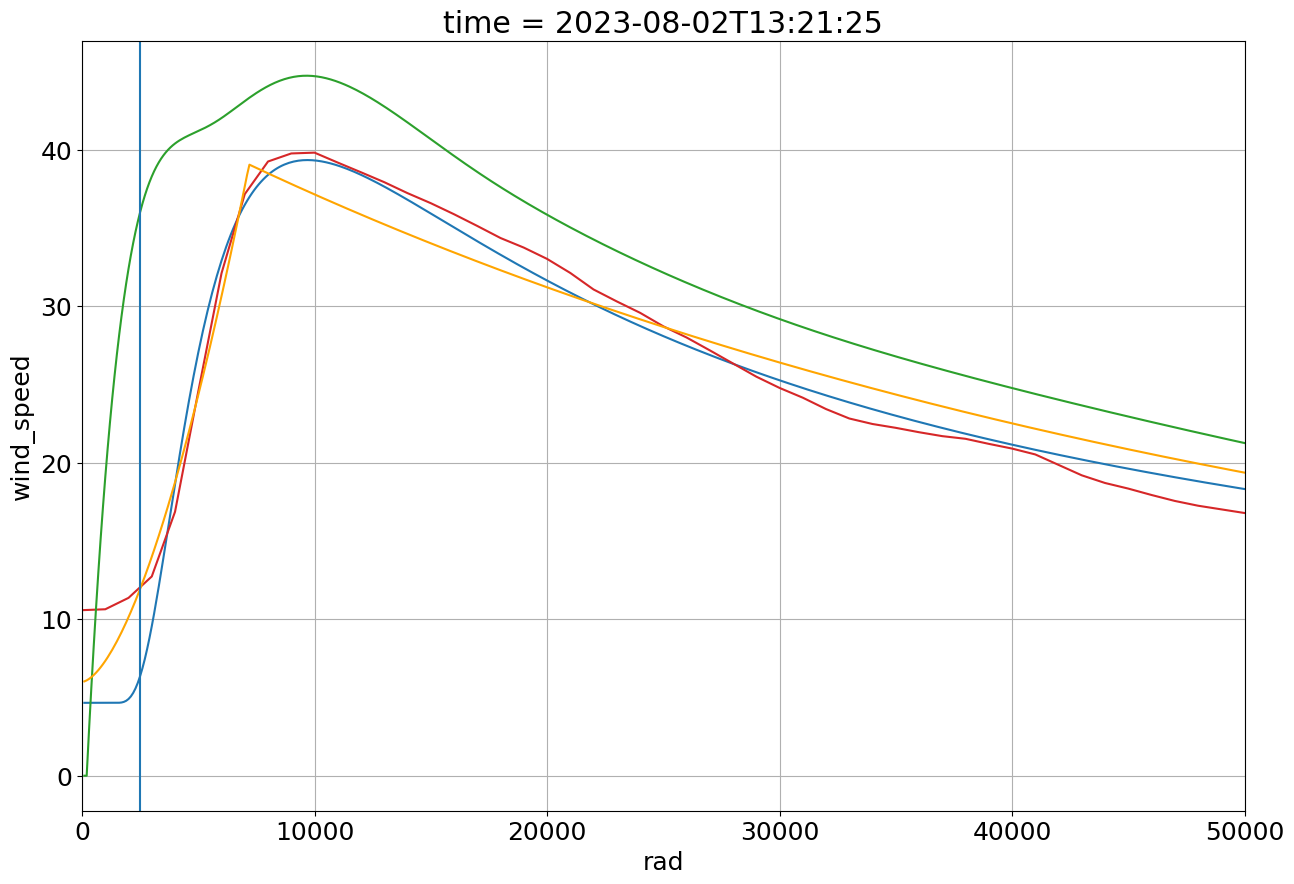

In [425]:
plt.plot(rs, V, c='tab:blue')
dsp.wind_speed.mean(dim='theta', skipna=True).plot(c='tab:red')
plt.plot(rs, V_smth, c='tab:green')
plt.plot(rs, Vw, c='orange')
plt.xlim(0, 50000)
plt.grid()
plt.axvline(2500)

### Apply Kepert

In [426]:
# Try
Vs  = np.stack([V_smth for i in range(np.shape(THs)[0])]) # Shape (361, 5000)
# Vs  = np.stack([Vw for i in range(np.shape(THs)[0])]) # Shape (361, 5000)

In [427]:
def get_wn1(thetas, wind_speed, initial_condition=15, upper_bound=80):
    '''
    initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
    upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
    '''
    # Fitting process
    popt, pcov = curve_fit(
        f=wn1,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi / 2, initial_condition],
        bounds=([0.1, 0., 0.1], [upper_bound, np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a, phi, c = popt[0], popt[1], popt[2]
    return a, phi, c

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [428]:
# Compute SAR asymmetries
# I_Vr         = (I(Rs, Vs, fcr) - Vs / rs)[0, :]                # I - V/r
# r_stt, r_end = rs[I_Vr <= 0][0], rs[I_Vr <= 0][-1] # Define the bounds
# Initialize
ass         = []
# valid_radii = np.array(dsp.rad.where((dsp.rad >= r_stt) & (dsp.rad <= r_end), drop=True))
valid_radii = xs = np.linspace(1000, 250000, 250)
# Iterate over all radii
for rad in tqdm(valid_radii): # Iterate only in the valid range to optimize time
    valid_dsp = dsp.sel(rad=rad, method='nearest').dropna(subset=['wind_speed'], dim='theta')
    a, phi, c = get_wn1(np.deg2rad(valid_dsp.theta), valid_dsp.wind_speed, float(ds.vps), float(ds.vmx))
    avg_ws    = float(valid_dsp.wind_speed.mean(dim='theta'))
    error     = float(rmse(wn1(np.deg2rad(valid_dsp.theta), a, phi, c), valid_dsp.wind_speed)) 
    if error < eps * avg_ws: # check that the fit did well
        ass.append(a)
    else:
        ass.append(np.nan)

  0%|          | 0/250 [00:00<?, ?it/s]

In [429]:
def get_kepert_asymmetries(THs, Rs, ths, rs, Vs, Ut, K, C, fcr, valid_radii):
    # Estimate the wind at the top of the BL with the wind reduction factor
    wrf          = wind_reduction_factor(Rs, Vs, K, C, fcr) # azimuthal wind
    Vs_try       = Vs / wrf

    # Apply Kepert's model
    u_K01, v_K01 = kepert2001(THs, Rs, Vs_try, Ut, K, C, fcr) # Takes 3-4 seconds
    kep_pol      = get_xrDataset_polar(rs, ths, u_K01, v_K01)

    # Compute asymmetries on Kepert wind field
    aks         = []
    # Iterate over all radii
    for rad in tqdm(valid_radii): # Iterate only in the valid range to optimize time
        ak, _, _  = get_wn1(np.deg2rad(kep_pol.theta), kep_pol.wind_speed.sel(rad=rad, method='nearest'), np.max(Vs[0, :]) / 3, np.max(Vs[0, :]))
        aks.append(ak)
    
    return aks, kep_pol

def get_asymmetries_difference(K, THs, Rs, ths, rs, Vs, Ut, C, fcr, valid_radii, ass):
    aks, _ = get_kepert_asymmetries(THs, Rs, ths, rs, Vs, Ut, K, C, fcr, valid_radii)
    diffs  = abs(np.array(aks) - np.array(ass))
    diff   = diffs.mean()
    print(diff)
    return diff

In [430]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  =0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return(mpl.colors.ListedColormap(colors, name="custom", N=nbCol))

palette = '/home/arthur/scripts/tools/high_wind_speed.pal'
cwnd         = getColorMap(rgbFile=palette)
normalizer   = Normalize(0, 80)

In [431]:
# BL characteristics
C  = 1.5e-3            # fixed
Ks = [1, 50, 100, 150] # trial

xs = valid_radii

# Colors
truncated_Reds = truncate_colormap(mpl.cm.Reds, 0.2, 1.)
colors         = truncated_Reds(np.linspace(0, 1, len(Ks)))

In [432]:
# Kepert model
AKS = dict.fromkeys(Ks)
for i, K in enumerate(tqdm(Ks)):
    aks, kep_pol = get_kepert_asymmetries(THs, Rs, ths, rs, Vs, Ut, K, C, fcr, xs)
    AKS[K]       = aks

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipykernel_48765/1839899701.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap         = mpl.cm.get_cmap('PuOr') # Spectral


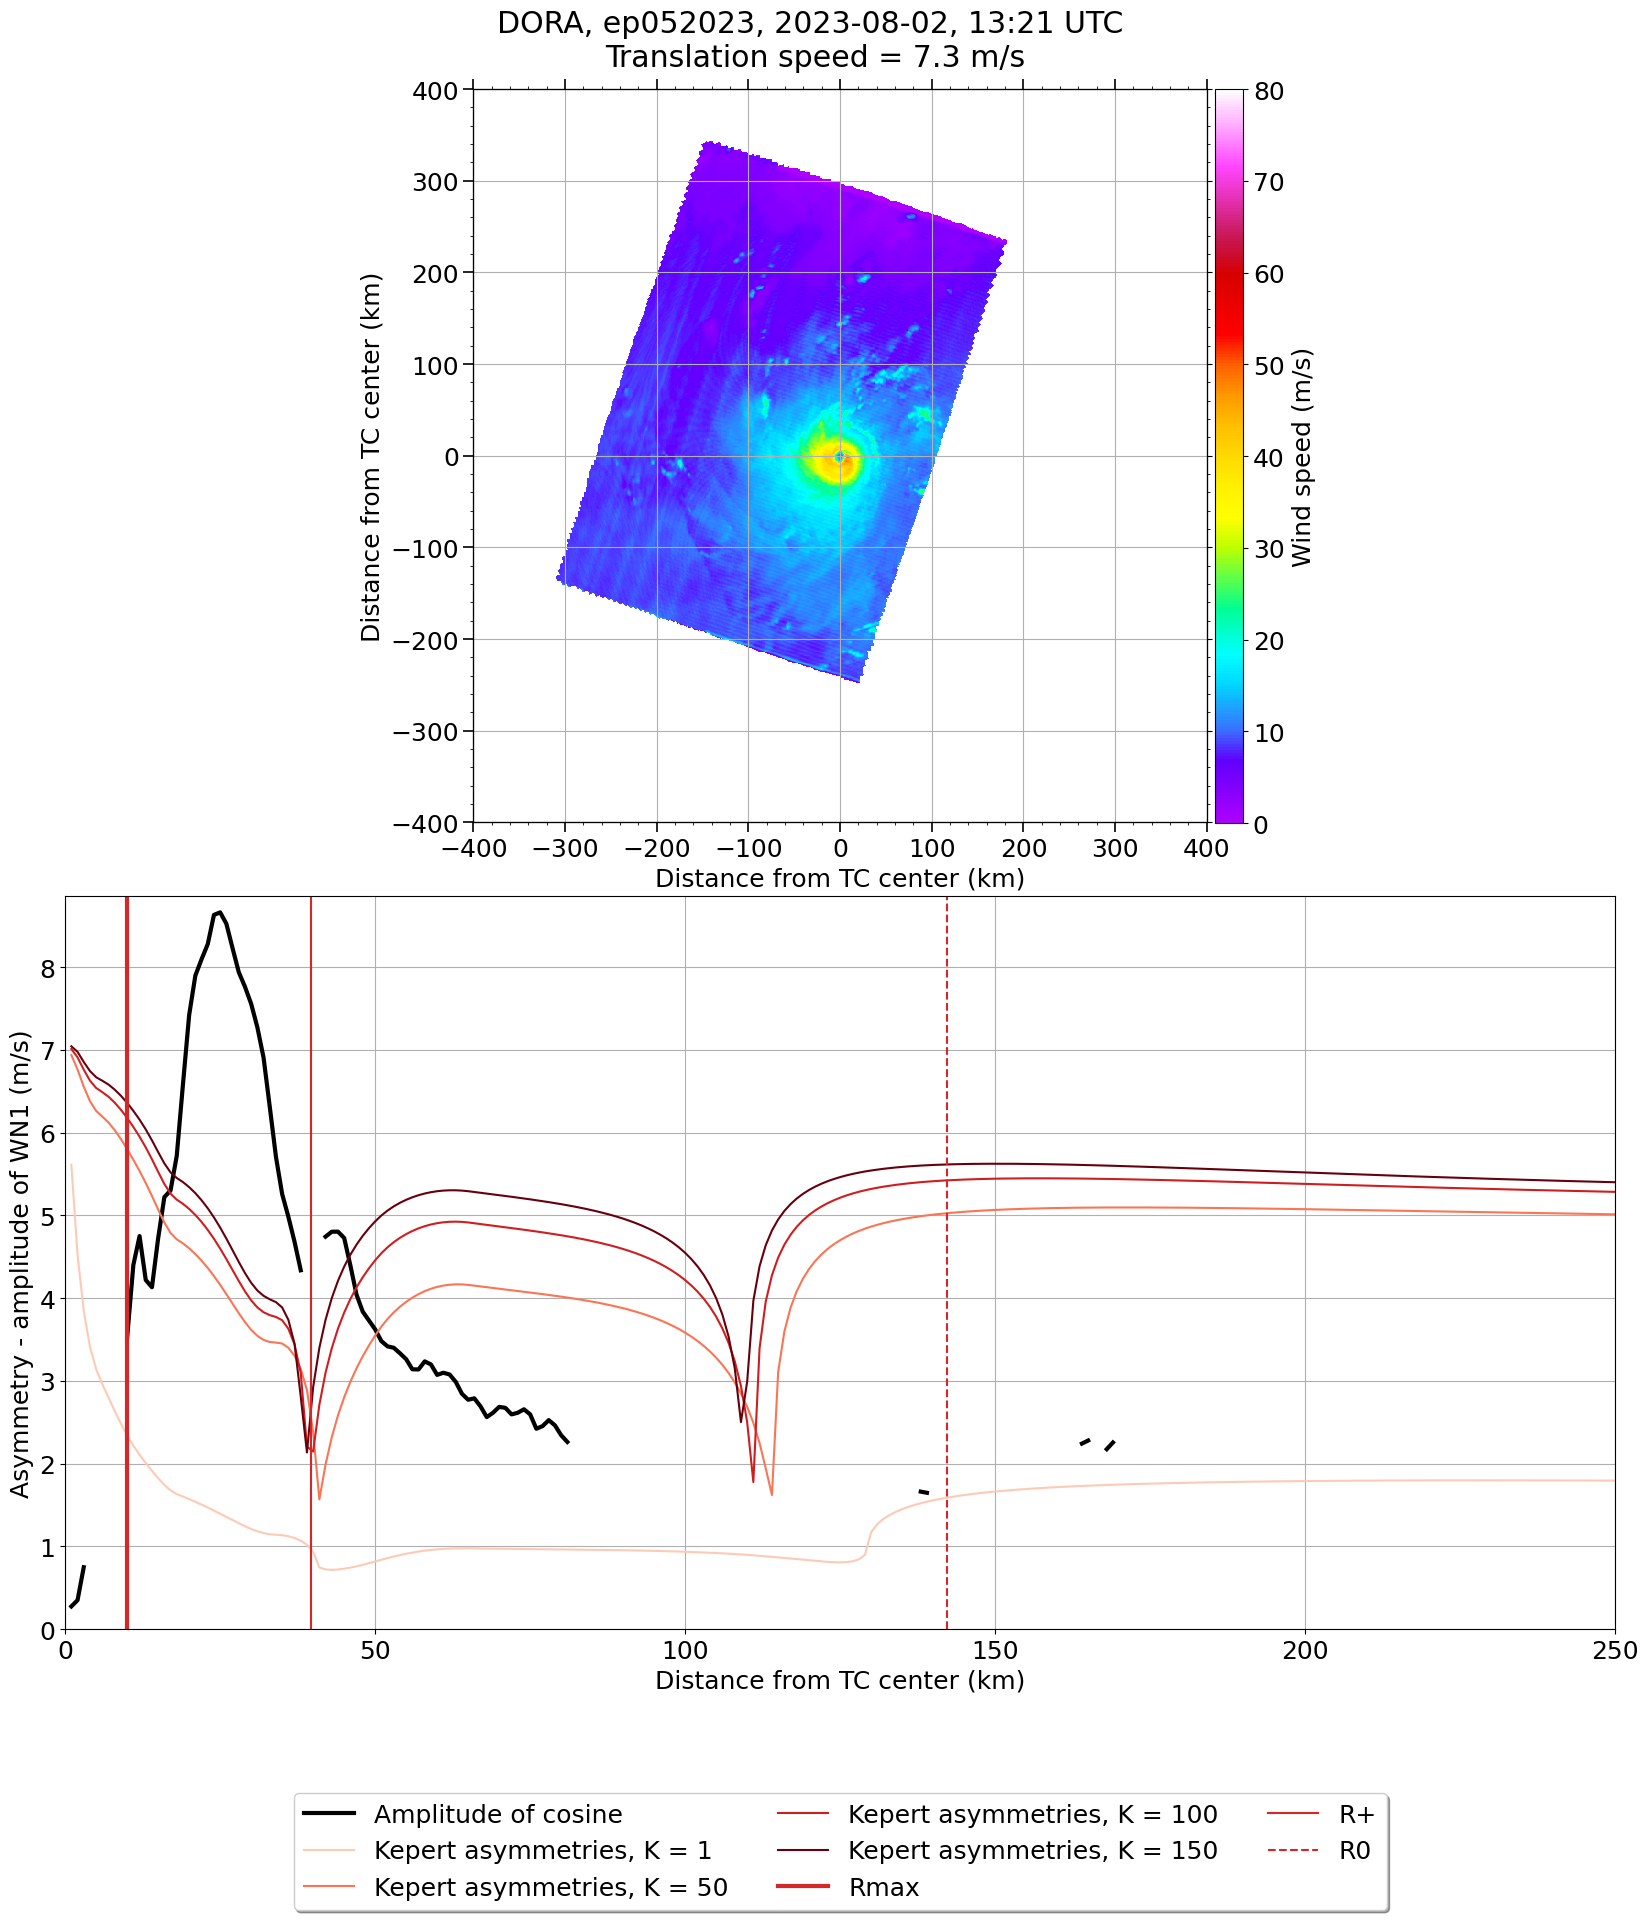

In [433]:
############
### Plot ###
############
fig          = plt.figure(figsize=(20, 20))
gs           = GridSpec(2, 1, hspace=0.1, wspace=0.01)
cmap         = mpl.cm.get_cmap('PuOr') # Spectral
normalizer   = Normalize(0, 80)
ax_lims2D    = 400
ts           = pd.to_datetime(str(ds.time.values)) 
d            = ts.strftime('%Y-%m-%d, %H:%M')
plt.suptitle('{}, {}, {} UTC \nTranslation speed = {:.1f} m/s'.format(ds.name.item(), ds.id.item(), d, ds.speed), y=0.92)

### Plot SAR
ax           = fig.add_subplot(gs[0, 0])
dr, th       = np.meshgrid(dsp.rad, np.deg2rad(dsp.theta))
ds_x, ds_y   = pol2cart(dr, th)
ws_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(dsp.wind_speed.transpose()).flatten(), (x_ref, y_ref), method='linear')
im           = ax.pcolormesh(x_ref / 1000, y_ref / 1000, ws_car, cmap=cwnd, norm=normalizer)

# Axes
ax.set_xlim(-ax_lims2D, ax_lims2D);ax.set_ylim(-ax_lims2D, ax_lims2D)
ax.set_ylabel(r'Distance from TC center (km)')
ax.set_xlabel(r'Distance from TC center (km)')
ax.set_box_aspect(1)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.grid()

ax2 = ax.twinx().twiny() 
ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
ax2.minorticks_on()
ax2.tick_params(axis='both', length=7, width=1.2)
ax2.set_box_aspect(1)
ax2.set_yticklabels([])
ax2.set_xticklabels([])

# Colorbar
cb_ax = fig.add_axes([0.7, 0.513, 0.014, 0.367])
cbar  = fig.colorbar(im, cax=cb_ax)
cbar.set_label(r'Wind speed (m/s)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

### Plot asymmetries (SAR + Kepert)
ax       = fig.add_subplot(gs[1, 0])

ax.plot(valid_radii / 1000, ass,                 c='k',          linewidth=3,        label='Amplitude of cosine')
# ax.plot(ds.rad / 1000, ds.quantile_diff,       c='tab:blue',   linewidth=3,        label='10%-quantile difference')
# Kepert asymmetry profiles
for i, K in enumerate(Ks):
    ax.plot(valid_radii / 1000, AKS[K],                 c=colors[i],                        label='Kepert asymmetries, K = {}'.format(K))
# Wind radii
ax.axvline(ds.rmx / 1000,                      c='tab:red',    linewidth=3,        label='Rmax')
ax.axvline(ds.rps / 1000,                      c='tab:red',                        label='R+')
ax.axvline(ds.r0 / 1000,                       c='tab:red',    linestyle='dashed', label='R0')

# # I ~ V/r
# ax.axvline(ds.I_Vr1 / 1000,                    c='orange',                         label='I ~ V/r with SAR wind speed (not BL-top)')
# ax.axvline(ds.I_Vr2 / 1000,                    c='orange')

# Validity curves
# ax.plot(ds.rad / 1000, ds.inertial_ratio,      c='green',      linewidth=3,        label='Inertial ratio - must be close to 1')
# ax.plot(ds.rad / 1000, ds.valid_thetas / 360., c='green',                          label='Percentage of valid thetas - must be close to 1')
# ax.plot(ds.rad / 1000, ds.translat_ratio,      c='green',      linestyle='dashed', label='Ut / V - must remain small')
# ax.axhline(1, c='gray', alpha=0.3)
# Legends
ax.set_xlabel(r'Distance from TC center (km)')
ax.set_ylabel('Asymmetry - amplitude of WN1 (m/s)')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=3, fancybox=True, shadow=True)
ax.set_xlim(0, max(float(ds.r0 / 1000) + 5, 250))
ax.set_ylim(0, max(ass) + 0.2)
ax.grid()

### Save
# plt.savefig(PTHS['sav_dir'] + ds.file.item().split('.')[0] + '_asym', bbox_inches='tight', format='png');plt.clf()